## Library

In [1]:
from ds_common_utils.aux.io.snowflake_tools import SnowflakeTools
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import matplotlib.lines as mlines

# Prep

## Connection

In [2]:
con = SnowflakeTools(
    role="INSIGHT_ANALYST_MERCH_DE_GENERAL_PRD",
    warehouse="INSIGHT_ANALYST_WH",
    database="BDWPRD_DE",
    schema="IA_MERCH_DE"
)

## Item list

In [3]:
# Load both AU and NZ sheets from the Excel file
item_list = pd.read_excel("Item list.xlsx", sheet_name=None)

# Replace sheet names if needed
au_items = item_list['AU']
nz_items = item_list['NZ']

# Standardise column names (optional but helpful)
au_items.columns = au_items.columns.str.strip().str.lower()
nz_items.columns = nz_items.columns.str.strip().str.lower()

# Ensure item_number is string with leading zeroes
au_items['item_number'] = au_items['item_number'].astype(str).str.zfill(7)
nz_items['item_number'] = nz_items['item_number'].astype(str).str.zfill(7)

In [4]:
# Read product hierarchy
product_hierarchy = con.read_sql_file_into_pandas(
    file="sql/item-hierarchy.sql"
)

snowflake_tools - 2025-06-12 16:21:50.554298+10:00 - Generating new token with 'INSIGHT_ANALYST_MERCH_DE_GENERAL_PRD' role and 'SESSION:ROLE-ANY' scope...
snowflake_tools - 2025-06-12 16:22:48.507227+10:00 - Saved token with '2025-06-12 20:22:48+10:00' expiry...


In [5]:
# Clean column names
product_hierarchy.columns = (
    product_hierarchy.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
)

# Ensure item_number is string with 7-digit padding
product_hierarchy['item_number'] = product_hierarchy['item_number'].astype(str).str.zfill(7)

In [6]:
# Merge enriched hierarchy into AU and NZ item lists
au_items_enriched = au_items.merge(product_hierarchy, on='item_number', how='left')
nz_items_enriched = nz_items.merge(product_hierarchy, on='item_number', how='left')


In [7]:
# Function to print unique values for each hierarchy column
def show_unique_hierarchy(df, label):
    print(f"\n🔹 {label}: Unique item_category_name")
    print(df['item_category_name'].dropna().unique())

    print(f"\n🔹 {label}: Unique item_department_name")
    print(df['item_department_name'].dropna().unique())

    print(f"\n🔹 {label}: Unique item_sub_department_name")
    print(df['item_sub_department_name'].dropna().unique())

    print(f"\n🔹 {label}: Unique item_class_name")
    print(df['item_class_name'].dropna().unique())

    print(f"\n🔹 {label}: Unique item_sub_class_name")
    print(df['item_sub_class_name'].dropna().unique())

# Show for both AU and NZ
show_unique_hierarchy(au_items_enriched, "AU ITEMS")
show_unique_hierarchy(nz_items_enriched, "NZ ITEMS")



🔹 AU ITEMS: Unique item_category_name
['200 TIMBER']

🔹 AU ITEMS: Unique item_department_name
['300 INDOOR TIMBER AND BOARDS']

🔹 AU ITEMS: Unique item_sub_department_name
['400 PANELS']

🔹 AU ITEMS: Unique item_class_name
['500 PANELS' '500 PANELS BULK STACK']

🔹 AU ITEMS: Unique item_sub_class_name
['600 EXOTIC PANELS' '600 PANELS BULK STACK' '600 PANELS'
 '600 DRESSED PINE PNL BULK STCK']

🔹 NZ ITEMS: Unique item_category_name
['200 TIMBER']

🔹 NZ ITEMS: Unique item_department_name
['300 INDOOR TIMBER AND BOARDS']

🔹 NZ ITEMS: Unique item_sub_department_name
['400 PANELS']

🔹 NZ ITEMS: Unique item_class_name
['500 PANELS' '500 PANELS BULK STACK']

🔹 NZ ITEMS: Unique item_sub_class_name
['600 EXOTIC PANELS' '600 PANELS' '600 PANELS BULK STACK'
 '600 DRESSED PINE PNL BULK STCK']


## Timeline

In [20]:
start_date = "'2024-08-26'"
end_date = "'2025-06-08'"
start_rrp_date = "2025-02-24"

start_date_LY = "'2023-08-26'"
end_date_LY = "'2024-06-08'"
start_rrp_date_LY = "2024-02-24"

# Class-based Performance

In [21]:
# Define time parameters and loyalty filter
params = {
    'AU': {
        'start_date': start_date,
        'end_date': end_date,
        'start_rrp_date': start_rrp_date,
        'start_date_LY': start_date_LY,
        'end_date_LY': end_date_LY,
        'start_rrp_date_LY': start_rrp_date_LY,
        'loyalty_filter': "AND stl.dw_loyalty_flybuys_account_id != MD5_BINARY(-1)"
    },
    'NZ': {
        'start_date': start_date,
        'end_date': end_date,
        'start_rrp_date': start_rrp_date,
        'start_date_LY': start_date_LY,
        'end_date_LY': end_date_LY,
        'start_rrp_date_LY': start_rrp_date_LY,
        'loyalty_filter': ""  # No loyalty filter for NZ
    }
}

In [22]:
# Define reusable preparation function
def prepare_df(df, enriched_items, cutoff_date, year_label, country_label):
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
    df['item_number'] = df['item_number'].astype(str).str.zfill(7)
    df['week_start'] = pd.to_datetime(df['week_start'])
    df['rrp_increase'] = df['item_number'].isin(enriched_items['item_number']).map({True: 'Yes', False: 'No'})
    df['period'] = df['week_start'].apply(lambda x: 'Pre' if x < pd.to_datetime(cutoff_date) else 'Post')
    df['year_label'] = year_label
    df['country'] = country_label
    return df

In [23]:
df_all_list = []

for country, cfg in params.items():
    # Read This Year
    df_ty = con.read_sql_file_into_pandas(
        file="sql/class-transactions.sql",
        formatting={
            'start_date': cfg['start_date'],
            'end_date': cfg['end_date'],
            'country': f"'{country}'",
            'loyalty_filter': cfg['loyalty_filter']
        }
    )

    # Read Last Year
    df_ly = con.read_sql_file_into_pandas(
        file="sql/class-transactions.sql",
        formatting={
            'start_date': cfg['start_date_LY'],
            'end_date': cfg['end_date_LY'],
            'country': f"'{country}'",
            'loyalty_filter': cfg['loyalty_filter']
        }
    )

    # Clean and tag
    df_ty = prepare_df(df_ty, au_items_enriched, cfg['start_rrp_date'], 'This Year', country)
    df_ly = prepare_df(df_ly, au_items_enriched, cfg['start_rrp_date_LY'], 'Last Year', country)

    # Add to list
    df_all_list.extend([df_ty, df_ly])

# ---- Combine all ----
df_all = pd.concat(df_all_list, ignore_index=True)

In [42]:
# Merchant Week Tagging Function
def tag_merchant_week(date, is_ly=False):
    base_ty_start = pd.to_datetime("2024-08-26")  # Wk09 TY
    base_ly_start = base_ty_start - pd.DateOffset(years=1)  # same day last year
    anchor = base_ly_start if is_ly else base_ty_start
    delta_days = (pd.to_datetime(date) - anchor).days
    if 0 <= delta_days < 7 * 41:  # Wk09 to Wk49 = 41 weeks
        week_num = 9 + (delta_days // 7)
        return str(week_num).zfill(2)
    return None

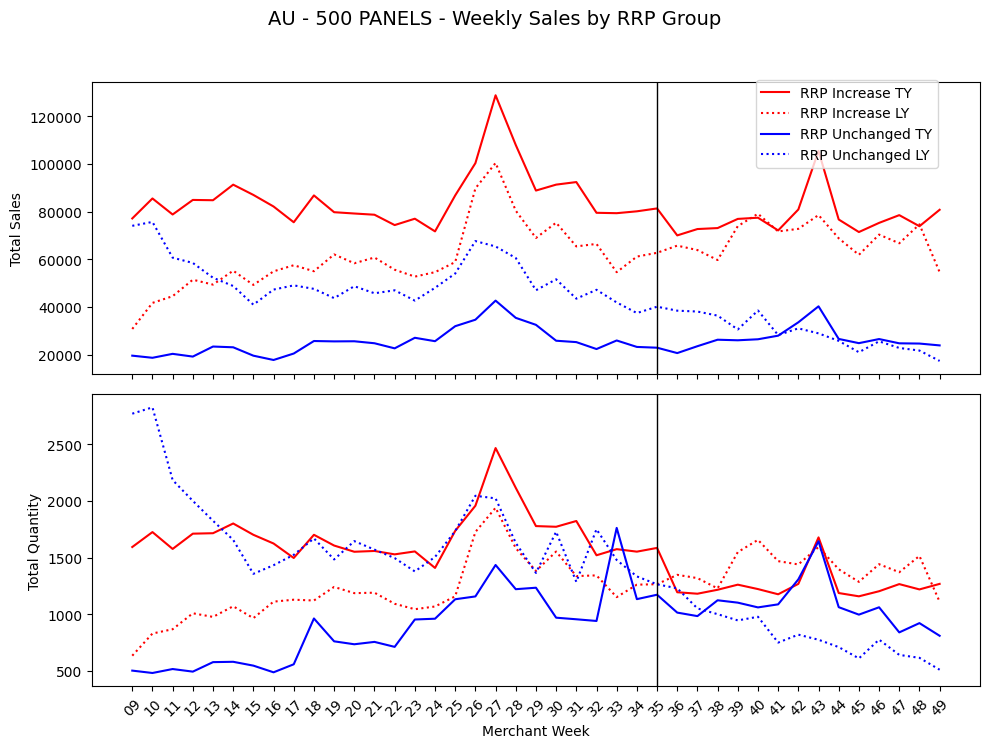

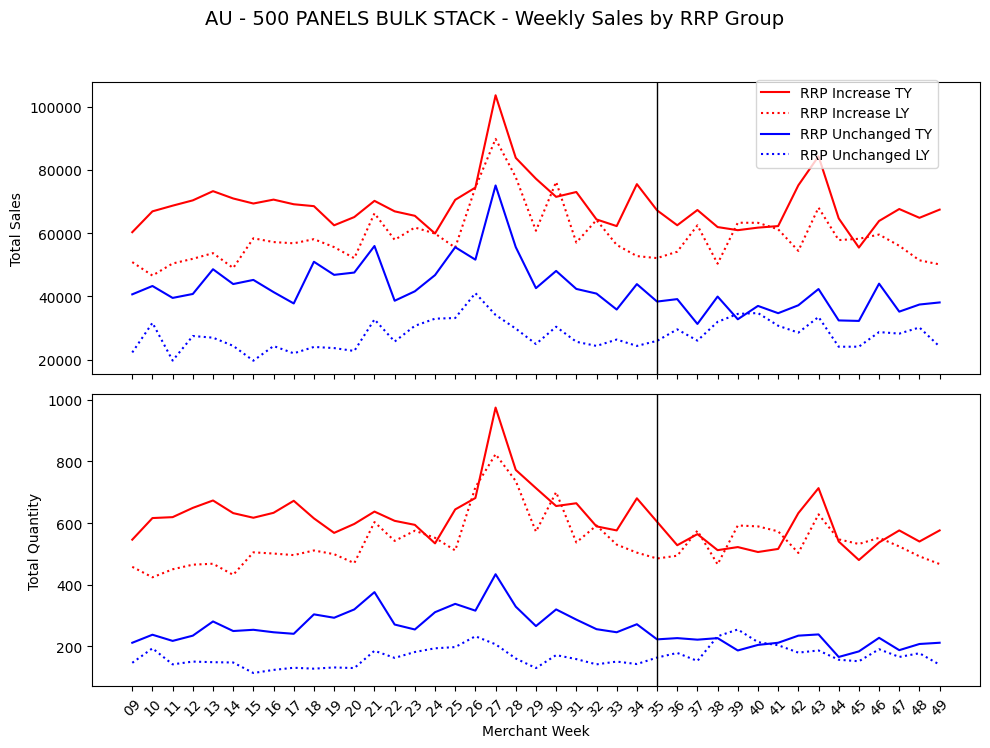

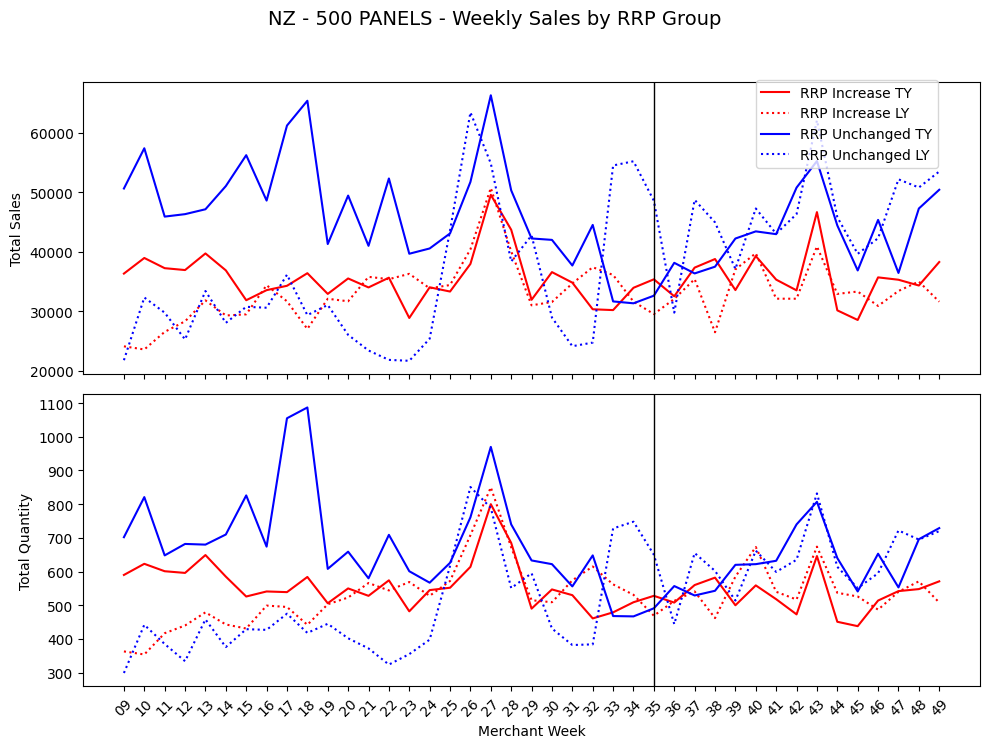

,country,item_class_name,rrp_increase,period,year_label,total_sales,total_quantity,avg_sales_per_week,avg_quantity_per_week
0,AU,500 PANELS,No,Post,Last Year,443775.66,12649.0,29585.04,843.27
1,AU,500 PANELS,No,Post,This Year,398105.56,16167.0,26540.37,1077.80
2,AU,500 PANELS,No,Pre,Last Year,1346168.15,44693.0,51775.70,1718.96
3,AU,500 PANELS,No,Pre,This Year,657541.41,22479.0,25290.05,864.58
4,AU,500 PANELS,Yes,Post,Last Year,1024876.15,20975.0,68325.08,1398.33
5,AU,500 PANELS,Yes,Post,This Year,1166512.85,19069.0,77767.52,1271.27
6,AU,500 PANELS,Yes,Pre,Last Year,1554545.44,30941.0,59790.21,1190.04
7,AU,500 PANELS,Yes,Pre,This Year,2230149.98,44145.0,85775.00,1697.88
8,AU,500 PANELS BULK STACK,No,Post,Last Year,435197.54,2754.0,29013.17,183.60
9,AU,500 PANELS BULK STACK,No,Post,This Year,552359.55,3163.0,36823.97,210.87


In [30]:
plot_colors = {'Yes': 'red', 'No': 'blue'}
line_styles = {'This Year': 'solid', 'Last Year': 'dotted'}

formatted_class_summaries = []

for (country, class_name), df_class in df_all.groupby(['country', 'item_class_name']):
    df_class = df_class.copy()
    
    # Tag merchant weeks
    df_class['merchant_week'] = df_class.apply(
        lambda row: tag_merchant_week(row['week_start'], is_ly=(row['year_label'] == 'Last Year')),
        axis=1
    )
    df_class = df_class[df_class['merchant_week'].notna()]  # Keep only tagged weeks

    # Aggregate for plotting
    df_weekly = df_class.groupby(
        ['merchant_week', 'rrp_increase', 'year_label']
    )[['total_sales', 'total_quantity']].sum().reset_index()

    # Summary metrics
    df_summary = df_class.groupby([
        'country', 'item_class_name', 'rrp_increase', 'period', 'year_label'
    ]).agg(
        total_sales=('total_sales', 'sum'),
        total_quantity=('total_quantity', 'sum'),
        weeks=('week_start', pd.Series.nunique)
    ).reset_index()

    df_summary['avg_sales_per_week'] = (df_summary['total_sales'] / df_summary['weeks']).round(2)
    df_summary['avg_quantity_per_week'] = (df_summary['total_quantity'] / df_summary['weeks']).round(2)
    df_summary = df_summary.drop(columns='weeks')
    formatted_class_summaries.append(df_summary)

    # Plotting 
    fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    fig.suptitle(f"{country} - {class_name} - Weekly Sales and Qty by RRP Group", fontsize=14)

    for ax, metric in zip(axes, ['total_sales', 'total_quantity']):
        for rrp_status in ['Yes', 'No']:
            for year_label in ['This Year', 'Last Year']:
                subset = df_weekly[
                    (df_weekly['rrp_increase'] == rrp_status) &
                    (df_weekly['year_label'] == year_label)
                ]
                ax.plot(
                    subset['merchant_week'],
                    subset[metric],
                    label=f"{rrp_status} - {year_label}",
                    color=plot_colors[rrp_status],
                    linestyle=line_styles[year_label]
                )
        ax.set_ylabel(metric.replace('_', ' ').title())
        ax.tick_params(axis='x', rotation=45)
        ax.axvline(x='35', color='black', linewidth=1)

    axes[-1].set_xlabel("Merchant Week")

    fig.legend(
        handles=[
            mlines.Line2D([], [], color='red', linestyle='solid', label='RRP Increase TY'),
            mlines.Line2D([], [], color='red', linestyle='dotted', label='RRP Increase LY'),
            mlines.Line2D([], [], color='blue', linestyle='solid', label='RRP Unchanged TY'),
            mlines.Line2D([], [], color='blue', linestyle='dotted', label='RRP Unchanged LY')
        ],
        bbox_to_anchor=(0.95, 0.9),
        ncol=1
    )

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

# Combine Summary Tables
final_summary_table = pd.concat(formatted_class_summaries, ignore_index=True)
final_summary_table

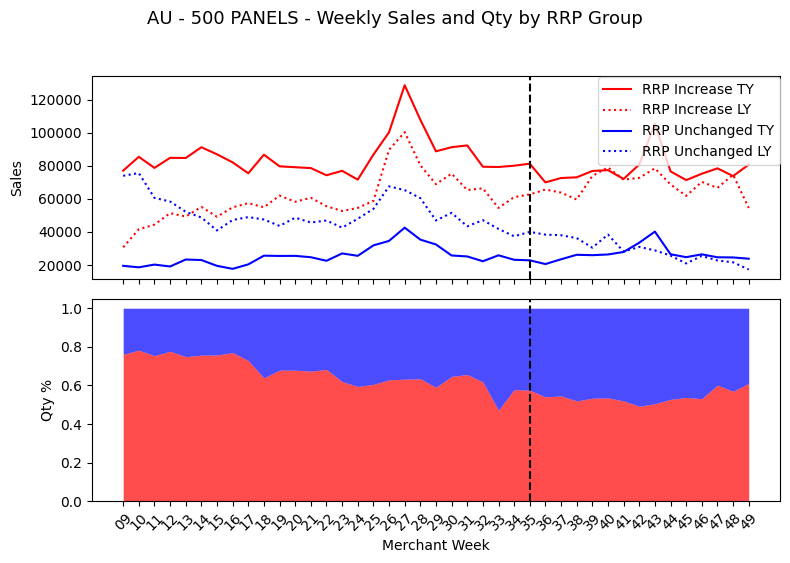

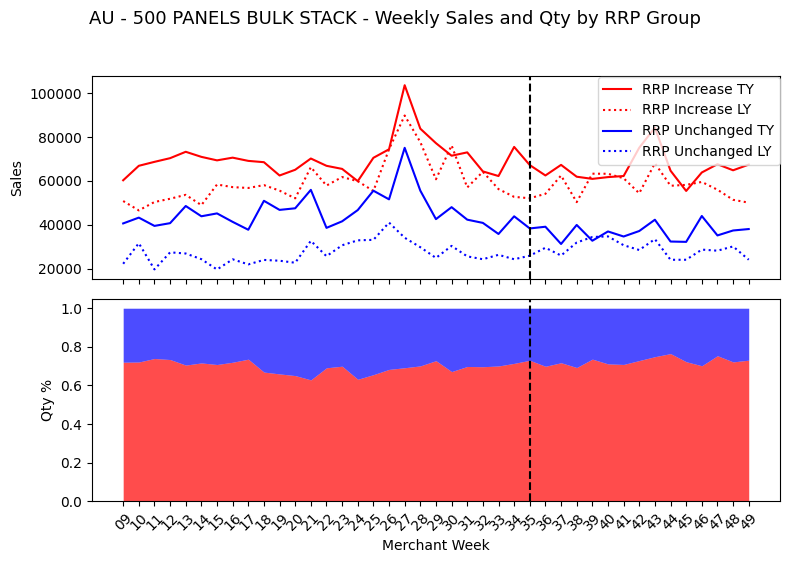

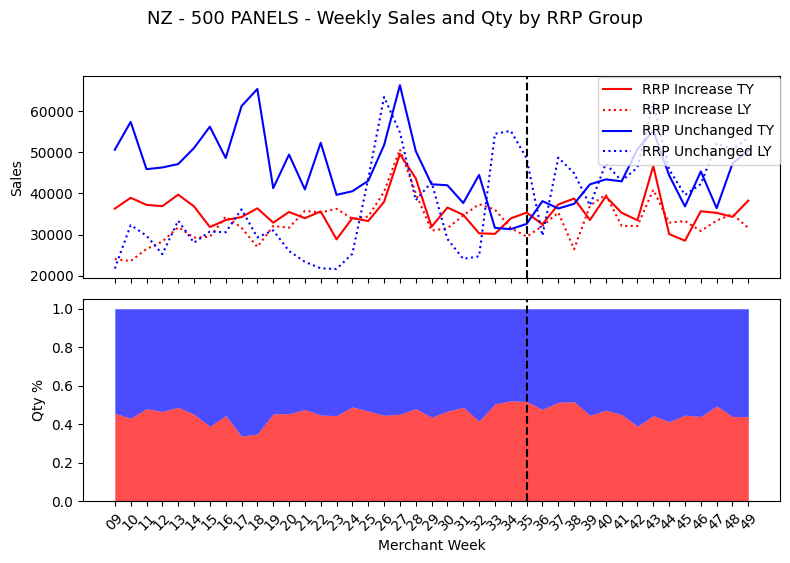

In [47]:
plot_colors = {'Yes': 'red', 'No': 'blue'}
line_styles = {'This Year': 'solid', 'Last Year': 'dotted'}

formatted_class_summaries = []
proportion = True  # Only affects total_quantity

for (country, class_name), df_class in df_all.groupby(['country', 'item_class_name']):
    df_class = df_class.copy()

    # Tag merchant weeks
    df_class['merchant_week'] = df_class.apply(
        lambda row: tag_merchant_week(row['week_start'], is_ly=(row['year_label'] == 'Last Year')),
        axis=1
    )
    df_class = df_class[df_class['merchant_week'].notna()]

    # Aggregate for plotting
    df_weekly = df_class.groupby(
        ['merchant_week', 'rrp_increase', 'year_label']
    )[['total_sales', 'total_quantity']].sum().reset_index()

    # Apply proportion transformation for quantity (TY only)
    if proportion:
        df_weekly['total_quantity'] = df_weekly.groupby(
            ['merchant_week', 'year_label']
        )['total_quantity'].transform(lambda x: x / x.sum())

    # Summary metrics
    df_summary = df_class.groupby([
        'country', 'item_class_name', 'rrp_increase', 'period', 'year_label'
    ]).agg(
        total_sales=('total_sales', 'sum'),
        total_quantity=('total_quantity', 'sum'),
        weeks=('week_start', pd.Series.nunique)
    ).reset_index()

    df_summary['avg_sales_per_week'] = (df_summary['total_sales'] / df_summary['weeks']).round(2)
    df_summary['avg_quantity_per_week'] = (df_summary['total_quantity'] / df_summary['weeks']).round(2)
    df_summary = df_summary.drop(columns='weeks')
    formatted_class_summaries.append(df_summary)

    # Plotting
    fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)  # Narrower figure
    fig.suptitle(f"{country} - {class_name} - Weekly Sales and Qty by RRP Group", fontsize=13)

    # --- Line plot: Total Sales (TY and LY) ---
    ax_sales = axes[0]
    for rrp_status in ['Yes', 'No']:
        for year_label in ['This Year', 'Last Year']:
            subset = df_weekly[
                (df_weekly['rrp_increase'] == rrp_status) &
                (df_weekly['year_label'] == year_label)
            ]
            ax_sales.plot(
                subset['merchant_week'],
                subset['total_sales'],
                label=f"{rrp_status} - {year_label}",
                color=plot_colors[rrp_status],
                linestyle=line_styles[year_label]
            )
    ax_sales.set_ylabel("Sales")
    ax_sales.axvline(x='35', color='black', linestyle='--')
    ax_sales.tick_params(axis='x', rotation=45)

    # --- Stacked area plot: Total Quantity (TY only) ---
    ax_qty = axes[1]
    df_ty_qty = df_weekly[df_weekly['year_label'] == 'This Year']
    df_pivot = df_ty_qty.pivot(
        index='merchant_week',
        columns='rrp_increase',
        values='total_quantity'
    ).fillna(0)

    df_pivot[['Yes', 'No']].plot.area(
        stacked=True,
        color=[plot_colors['Yes'], plot_colors['No']],
        ax=ax_qty,
        alpha=0.7,
        linewidth=0,
        legend=False  # Remove legend here
    )
    ax_qty.set_ylabel("Qty %")
    ax_qty.axvline(x='35', color='black', linestyle='--')
    ax_qty.tick_params(axis='x', rotation=45)

    axes[-1].set_xlabel("Merchant Week")
    
    # Legend only for sales
    fig.legend(
        handles=[
            mlines.Line2D([], [], color='red', linestyle='solid', label='RRP Increase TY'),
            mlines.Line2D([], [], color='red', linestyle='dotted', label='RRP Increase LY'),
            mlines.Line2D([], [], color='blue', linestyle='solid', label='RRP Unchanged TY'),
            mlines.Line2D([], [], color='blue', linestyle='dotted', label='RRP Unchanged LY')
        ],
        bbox_to_anchor=(0.99, 0.88),
        ncol=1
    )

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

# Combine summary tables
final_summary_table = pd.concat(formatted_class_summaries, ignore_index=True)

# Basket

In [25]:
copurchase_results = []

for country, cfg in params.items():
    print(f"Running co-purchase for {country}...")

    df_copurchase = con.read_sql_file_into_pandas(
        file="sql/co-purchases.sql",
        formatting={
            'start_date': cfg['start_date'],
            'end_date': cfg['end_date'],
            'rrp_cutoff': f"'{cfg['start_rrp_date']}'",
            'country': f"'{country}'",
            'loyalty_filter': cfg['loyalty_filter']
        }
    )

    copurchase_results.append(df_copurchase)

df_all_copurchases = pd.concat(copurchase_results, ignore_index=True)


Running co-purchase for AU...


DatabaseError: Execution failed on sql 'WITH item_txns AS (
    SELECT
        stl.dw_sales_transaction_id AS transaction_id,
        i.item_number AS primary_item_number,
        i.item_class_name AS primary_item_class_name,
        CASE 
            WHEN stl.transaction_date < '2025-02-24' THEN 'Pre'
            ELSE 'Post'
        END AS period,
        stl.transaction_date
    FROM bdwprd_cds.sales.sales_transaction_line_fct stl
    JOIN bdwprd_cds.item.item_dim i
        ON stl.dw_item_id = i.dw_item_id
    WHERE 1=1
        AND stl.transaction_date BETWEEN '2024-08-26' AND '2025-06-08'
        AND i.item_class_name IN ('500 PANELS', '500 PANELS BULK STACK')
        AND i.item_department_name != '.Unk'
        AND stl.sales_reporting_include_ind = TRUE
        AND stl.dw_loyalty_flybuys_account_id != MD5_BINARY(-1)
        AND stl.customer_type_code = 'Consumer'
        AND stl.country_code = 'AU'
),

copurchase_items AS (
    SELECT
        it.primary_item_number,
        it.primary_item_class_name,
        it.period,
        cp.item_number AS copurchased_item_number,
        COUNT(DISTINCT it.transaction_id) AS primary_item_txn_count,
        COUNT(DISTINCT CASE WHEN cp.item_number != it.primary_item_number THEN it.transaction_id END) AS copurchase_txn_count
    FROM item_txns it
    JOIN bdwprd_cds.sales.sales_transaction_line_fct cp
        ON it.transaction_id = cp.dw_sales_transaction_id
    JOIN bdwprd_cds.item.item_dim cp_i
        ON cp.dw_item_id = cp_i.dw_item_id
    WHERE cp.item_number != it.primary_item_number
    GROUP BY
        it.primary_item_number,
        it.primary_item_class_name,
        it.period,
        cp.item_number
),

copurchase_details AS (
    SELECT
        ci.*,
        i.item_description,
        i.item_class_name,
        i.item_sub_class_name,
        i.item_sub_department_name,
        i.item_department_name,
        ROUND(copurchase_txn_count * 100.0 / NULLIF(primary_item_txn_count, 0), 2) AS percent_of_primary_txns
    FROM copurchase_items ci
    LEFT JOIN bdwprd_cds.item.item_dim i
        ON ci.copurchased_item_number = i.item_number
)

SELECT
    ''AU'' AS country,
    *
FROM copurchase_details
ORDER BY primary_item_number, period, percent_of_primary_txns DESC
': 001003 (42000): SQL compilation error:
syntax error line 60 at position 8 unexpected ''''.

In [ ]:
df_all_copurchases

,PRIMARY_ITEM,COPURCHASED_ITEM,ITEM_DESCRIPTION,ITEM_SUB_CLASS_NAME,ITEM_CLASS_NAME,ITEM_SUB_DEPARTMENT_NAME,ITEM_DEPARTMENT_NAME,TXN_WITH_COPURCHASE,TOTAL_TXNS,PERCENT_OF_TXNS,country
0,0019147,0264107,FT VERONA BLACK++TILE WRITE OFF,602 PORCELAIN FLOOR TILE,501 FLOOR TILES,401 TILES AND SHEETING,300 FLOORING,1,5,20.0,AU
1,0019147,0264107,TILE FLOOR PRCLN GAYAFOR CTN5++TILE WRITE OFF,602 PORCELAIN FLOOR TILE,501 FLOOR TILES,401 TILES AND SHEETING,300 FLOORING,1,5,20.0,AU
2,0019147,2420065,SCREWS CSK LONG THRD ZP ZENITH++6GX20 PH PK45 ...,600 CSK TIMBER SCREWS,500 TIMBER SCREWS,400 SCREWS,300 FIXINGS,1,5,20.0,AU
3,0019147,1660146,ROLLER COVER LITTLE RIPPER++100MM 10PK HIGH DE...,600 MINI ROLLERS,500 PAINT ROLLERS,400 PAINT APPLICATORS,300 PAINT ACCESSORIES,1,5,20.0,AU
4,0019147,0361142,BRACKET LONDON ZENITH++125X100MM MB HCR4125,600 LD DECORATIVE BRACKETS,500 DECORATIVE SHELF BRACKETS,400 BRACKETS,300 HOOKS LEGS PROTECT SAFETY,1,5,20.0,AU
...,...,...,...,...,...,...,...,...,...,...,...
1315,8902287,0293996,65X18 RAD DSG UT++KD D4S 1.2M 6518DG12,600 PINE MLD UT CTL DG D4S,500 PINE MOULDINGS UT CTL,400 PINE MOULDINGS,300 INDOOR TIMBER AND BOARDS,13,1334,1.0,NZ
1316,8902287,0412867,140x18 DRESS GRADE PINE++UT KD D4S 1.2M,600 PINE UT CTL DG D4S,500 PINE MOULDINGS UT CTL,400 PINE MOULDINGS,300 INDOOR TIMBER AND BOARDS,12,1334,0.9,NZ
1317,8902287,0455952,OAK TIMBER ACOUSTIC PANEL++2400X600X21MM^,600 EXOTIC PANELS,500 PANELS,400 PANELS,300 INDOOR TIMBER AND BOARDS,11,1334,0.8,NZ
1318,8902287,0419616,PINE MULTI USE TIMBER PANEL++2200X600X26MM SPE...,600 PANELS BULK STACK,500 PANELS BULK STACK,400 PANELS,300 INDOOR TIMBER AND BOARDS,9,1334,0.7,NZ
